In [1]:
import os

import keras
import numpy as np
# ----------------------------------------------- data preparation ----------------------------------------------- #
question_index = str(2)

x_left_training = np.load(os.path.join('data/datasets/train_data/train_left_duel_' + question_index + '.npy'), allow_pickle=True)
x_right_training = np.load(os.path.join('data/datasets/train_data/train_right_duel_' + question_index + '.npy'), allow_pickle=True)
y_training = np.load(os.path.join('data/datasets/train_data/train_label_duel_' + question_index + '.npy'), allow_pickle=True)

# Shuffle data before training
# Determine batch size
batch_size = 32

# Determine number of batches
num_batches = len(x_left_training) // batch_size

# Generate random permutation of indices for each batch and shuffle data and labels using permutation of indices
for i in range(num_batches):
    start_index = i * batch_size
    end_index = (i + 1) * batch_size
    batch_indices = np.random.permutation(batch_size)
    x_left_training[start_index:end_index] = x_left_training[start_index:end_index][batch_indices]
    x_right_training[start_index:end_index] = x_right_training[start_index:end_index][batch_indices]
    y_training[start_index:end_index] = y_training[start_index:end_index][batch_indices]

# Shuffle any remaining data
if len(x_left_training) % batch_size != 0:
    start_index = num_batches * batch_size
    end_index = len(x_left_training)
    remaining_indices = np.random.permutation(end_index - start_index)
    x_left_training[start_index:end_index] = x_left_training[start_index:end_index][remaining_indices]
    x_right_training[start_index:end_index] = x_right_training[start_index:end_index][remaining_indices]
    y_training[start_index:end_index] = y_training[start_index:end_index][remaining_indices]

In [2]:
from source_codes import comparison_model
model = comparison_model.comparison_model_convfusion(backbone='vgg19',optimizer='adam',learning_rate=1e-6,decay=1e-7)
model.summary()
from keras import callbacks

# train model
save_model_results = r"model_training_results/Q2/nopreference_removed_results/Q2_from_Q1best_model_0_230423"

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(save_model_results, 'best_model_weights.h5'),
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)

early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=10,
                                         mode='min',
                                         verbose=1)
model.summary()
# train the best model 0
history = model.fit(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_2[0][0]',                
                                                                  'input_3[0][0]']            

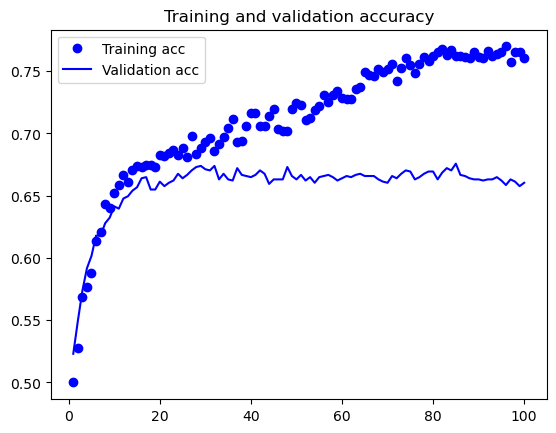

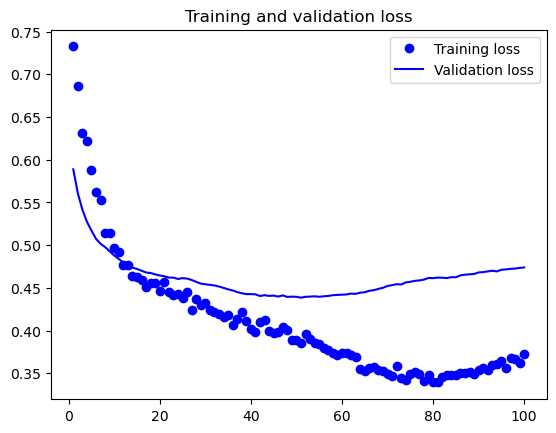

In [3]:
import pickle
import os
from source_codes.utils import plot_model_accuracy, plot_model_loss, save_structure_in_json

folder_path = save_model_results
model_history = history

# Save training history
with open(os.path.join(folder_path, 'history.pickle'), 'wb') as f:
    pickle.dump(model_history.history, f)

# Save model and plots of the performance
plot_model_accuracy(model_history, folder_path)
plot_model_loss(model_history, folder_path)
model_path = os.path.join(folder_path, 'model.h5')
model.save(model_path)

# Save model weights and structure
weights_path = os.path.join(folder_path, 'weights.h5')
model.save_weights(weights_path)
json_path = os.path.join(folder_path, 'structure.json')
save_structure_in_json(model, json_path)

In [7]:
# use Q1 weights to initialize Q2
from keras import optimizers
model = comparison_model.comparison_model_convfusion(backbone='vgg19',optimizer='adam',learning_rate=1e-6,decay=1e-7)

# tune the model
model.load_weights(r"good_models-removed_nopref/Q1/Q1_bestmodel0_hp230421_drop0.5_epoch100/best_model_weights.h5")
model.compile()

model.summary()

save_model_results = r"model_training_results/Q2/nopreference_removed_results/Q2_from_Q1bestmodel0_usingallQ1weights_230423"

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(save_model_results, 'best_model_weights.h5'),
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)

early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=10,
                                         mode='min',
                                         verbose=1)

# train the best model 0
history = model.fit(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

In [4]:
# use Q1 weights to initialize Q2
from keras import optimizers, callbacks
from source_codes import comparison_model

model = comparison_model.comparison_model_convfusion(backbone='vgg19',optimizer='adam',learning_rate=1e-6,decay=1e-7)

# tune the model
model.load_weights(r"good_models-removed_nopref/Q1/Q1_bestmodel0_hp230421_drop0.5_epoch100/best_model_weights.h5")
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate=1e-6, decay=1e-7),
    metrics = ['accuracy']
)

model.summary()

save_model_results = r"model_training_results/Q2/nopreference_removed_results/Q2_from_Q1bestmodel0_usingallQ1weights_230423"

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(save_model_results, 'best_model_weights.h5'),
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)

early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=10,
                                         mode='min',
                                         verbose=1)

# train the best model 0
history = model.fit(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

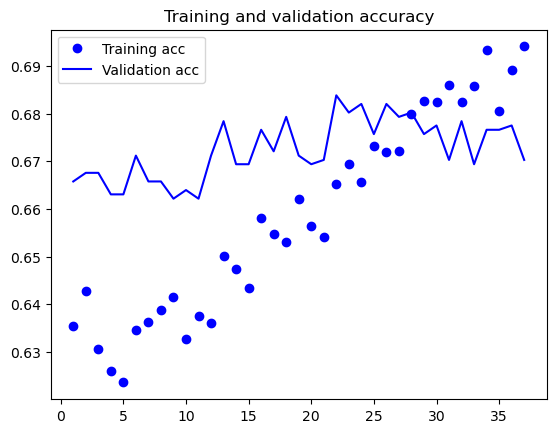

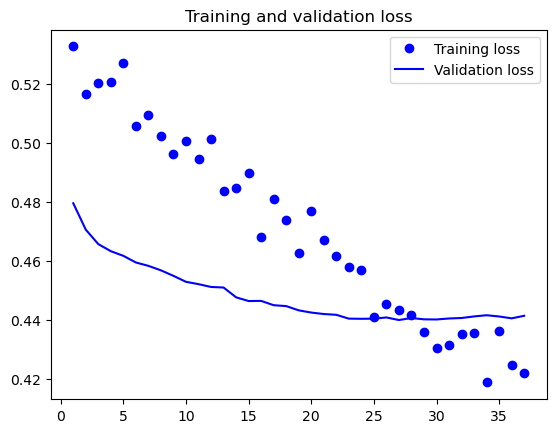

In [5]:
import pickle
import os
from source_codes.utils import plot_model_accuracy, plot_model_loss, save_structure_in_json

folder_path = save_model_results
model_history = history

# Save training history
with open(os.path.join(folder_path, 'history.pickle'), 'wb') as f:
    pickle.dump(model_history.history, f)

# Save model and plots of the performance
plot_model_accuracy(model_history, folder_path)
plot_model_loss(model_history, folder_path)
model_path = os.path.join(folder_path, 'model.h5')
model.save(model_path)

# Save model weights and structure
weights_path = os.path.join(folder_path, 'weights.h5')
model.save_weights(weights_path)
json_path = os.path.join(folder_path, 'structure.json')
save_structure_in_json(model, json_path)

In [7]:
# use Q1 weights to initialize Q2
from keras import optimizers, callbacks, models
model = models.load_model(r"good_models-removed_nopref/Q1/Q1_bestmodel0_hp230421_drop0.5_epoch100/model.h5")
model.load_weights(r"good_models-removed_nopref/Q1/Q1_bestmodel0_hp230421_drop0.5_epoch100/best_model_weights.h5")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_2[0][0]',                
                                                                  'input_3[0][0]']            

In [8]:
from keras import Model
model = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [9]:
from keras import layers,Sequential
top_q2 = Sequential([
    layers.Dense(1024, activation='relu', name='Dense_1'),
    # layers.Dropout(0.5),
    layers.Dense(512, activation='relu', name='Dense_2'),
    # layers.Dropout(0.5),
    layers.Dense(2, activation='softmax', name='Final_dense'),
])
model = Model(inputs=model.input, outputs=top_q2(model.output))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [10]:
model.load_weights = r"good_models-removed_nopref/Q1/Q1_bestmodel0_hp230421_drop0.5_epoch100/best_model_weights.h5"
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate=1e-6, decay=1e-7),
    metrics = ['accuracy']
)

model.summary()

save_model_results = r"model_training_results/Q2/nopreference_removed_results/Q2_from_Q1bestmodel0_usingQ1weightsforVGG19_finetuned_addtopdense_230424"

checkpoint = callbacks.ModelCheckpoint(
    os.path.join(save_model_results, 'best_model_weights.h5'),
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode='min',
    verbose=1)

early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=10,
                                         mode='min',
                                         verbose=1)

# train the best model 0
history = model.fit(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, 7, 7, 512)    20024384    ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

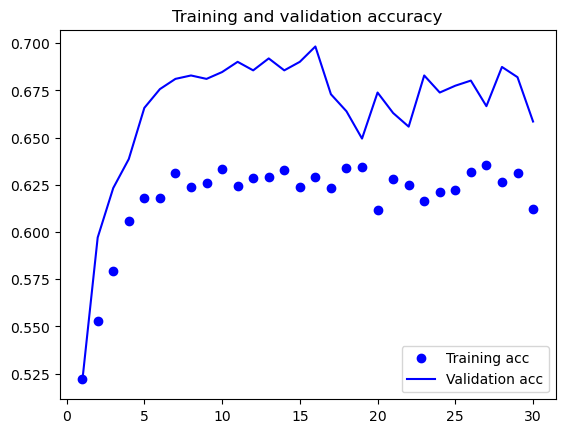

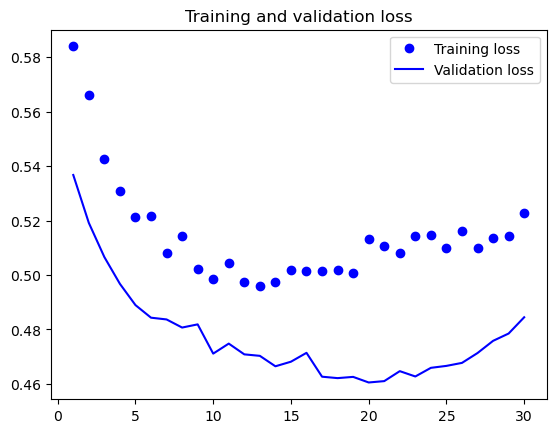

In [11]:
import pickle
import os
from source_codes.utils import plot_model_accuracy, plot_model_loss, save_structure_in_json

folder_path = save_model_results
model_history = history

# Save training history
with open(os.path.join(folder_path, 'history.pickle'), 'wb') as f:
    pickle.dump(model_history.history, f)

# Save model and plots of the performance
plot_model_accuracy(model_history, folder_path)
plot_model_loss(model_history, folder_path)
model_path = os.path.join(folder_path, 'model.h5')
model.save(model_path)

# Save model weights and structure
weights_path = os.path.join(folder_path, 'weights.h5')
model.save_weights(weights_path)
json_path = os.path.join(folder_path, 'structure.json')
save_structure_in_json(model, json_path)